# Facial Keypoint Detection

### 1) Setup and loading data 

The first few cells are concerned with loading libraries, data sets, and setting up train/dev/test sets


In [444]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from scipy.spatial import distance

import csv



In [445]:
data_directory = '../data/'
training_csv = 'training.csv'
test_csv = 'test.csv'

def space_separated_string_to_numpy_array(string):
    return np.fromstring(string, dtype=int, sep=" ")

def read_data_as_data_frame_with_image_array(data_directory, csv):
    return pd.read_csv(data_directory + csv, converters = { 
        'Image' : space_separated_string_to_numpy_array
    })

training_and_development_df = read_data_as_data_frame_with_image_array(data_directory, training_csv)
test_df = read_data_as_data_frame_with_image_array(data_directory, test_csv)
test_data = np.array([np.array(image) for image in test_df['Image'] ])
test_image_ids = np.array(test_df['ImageId'])

# The training_shuffle is used to randomly (but the same way every time) to split the data into
# training data and development data
# Set the randomizer seed so results are the same each time.
np.random.seed(0)
training_shuffle = np.random.permutation(len(training_and_development_df.index))

In [446]:
training_df = training_and_development_df[len(test_df.index):]
development_df = training_and_development_df[:len(test_df.index)]

training_df_columns = training_df.columns.values
training_df_training_columns = np.asarray([ 'Image' ])
training_df_label_columns = training_df_columns[np.where(training_df_columns != 'Image')]
def training_label_to_index(label):
    return np.where(training_df_label_columns == label)[0]
    
def index_to_training_label(index):
    return training_df_label_columns[index]

training_data = np.array([np.array(image) for image in training_df['Image'] ])
training_labels = np.array(training_df[training_df_label_columns])
development_data = np.array([np.array(image) for image in development_df['Image'] ])
development_labels = np.array(development_df[training_df_label_columns])
label_names = training_df_label_columns
x_label_indices = [ index for index, name in enumerate(label_names) if '_x' in name ]
y_label_indices = [ index for index, name in enumerate(label_names) if '_y' in name ]





## 2) A way to look at the data 

Showing an example, plotting but the labels/correct answers and predictions

In [447]:
def show_one_example(example, labels = None, predictions = None):
    
    matrix = np.reshape(255 - example, (96, 96))
    plt.imshow(matrix, cmap='Greys', interpolation='Nearest')
    if labels is not None:
        x_labels = labels[x_label_indices]
        y_labels = labels[y_label_indices]
        plt.scatter(x_labels, y_labels, c='g', marker = 'o')
    if predictions is not None:
        x_predictions = predictions[x_label_indices]
        y_predictions = predictions[y_label_indices]
        plt.scatter(x_predictions, y_predictions, c='r', marker='x')
    plt.tight_layout()
    plt.show()

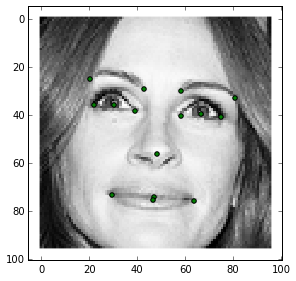

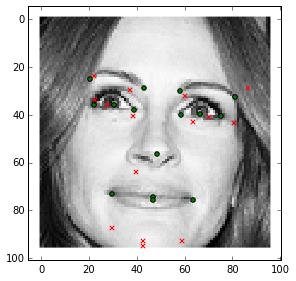

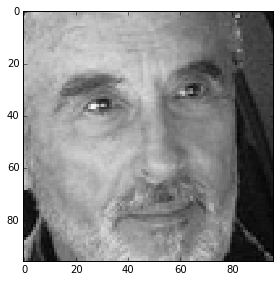

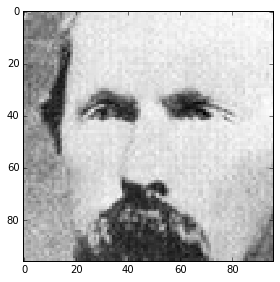

In [448]:
# intentially using the wrong predictions to show labels (green +) vs predictions (red x)
show_one_example(training_data[0], training_labels[0])
show_one_example(training_data[0], training_labels[0], training_labels[1])
show_one_example(training_data[100])
show_one_example(training_data[1000])

## 3) Computing of the error (we use pixel RMSE)

Some functions for overall fitness scoring (`development_score`) as well as for looking for errors

In [449]:
def compute_example_squared_errors(example_predicted, example_labels):
    return [ 
        (example_predicted[index] - label) ** 2
        for index, label 
        in enumerate(example_labels) 
    ]

def compute_error_squared_matrix(all_examples_predicted, all_examples_labels):
    return [
        compute_example_squared_errors(example_predicted, all_examples_labels[index])
        for index, example_predicted
        in enumerate(all_examples_predicted)
    ]

def rmse(error_matrix):
    return np.sqrt(np.nanmean(error_matrix))

def development_score(development_predictions):
    error_matrix = np.matrix(
        compute_error_squared_matrix(development_predictions, development_labels)
    )
    
    return rmse(error_matrix)

## 4) Establishing a baseline (simple mean of training algorithm)

*** Baseline development data score: 3.76889949349
*** Reference (R implementation score, some randomness): 3.758999
*** Baseline (mean coordinate) predictions on first example


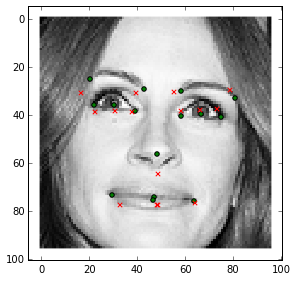

In [450]:

# Baseline - predict the mean keypoints for the training set
baseline_mean_predictions = {
        name: np.mean(
            [ 
                training_label[index] 
                for training_label 
                in training_labels 
                if training_label[index] >= 0.0
            ]
        )
        for index, name

        in enumerate(label_names)
    }

baseline_mean_predictions_array = np.array([ baseline_mean_predictions[name] for name in label_names ])

def baseline_mean_predict(example):
    return baseline_mean_predictions_array   

def baseline():
    baseline_development_predictions = [ 
        baseline_mean_predict(example) 
        for example 
        in development_data 
    ]
    
    baseline_development_score = development_score(baseline_development_predictions)
    print('*** Baseline development data score: ' + str(baseline_development_score))
    
    print('*** Reference (R implementation score, some randomness): 3.758999') 
    print('*** Baseline (mean coordinate) predictions on first example')
    
    show_one_example(training_data[0], training_labels[0], baseline_mean_predict(training_data[0]))
                     
baseline()

## 5) A very naive ML baseline - using KNearestNeighbors

We will use K nearest neighbors to predict each keypoint

In [451]:
neighbors = 5
def map_nan_to_0(value):
    if np.isnan(value):
        return 0.0
    else:
        return value
    
training_0_labels = np.array([
    map_nan_to_0(label[0])
    for label
    in training_labels
])

training_0_labels

training_labels_nansafe = np.vectorize(map_nan_to_0)(training_labels)
training_labels_nansafe

knn = KNeighborsClassifier(neighbors)
knn.fit(training_data, training_labels_nansafe)

dev_knn_predictions = knn.predict(development_data)

#training_0_labels


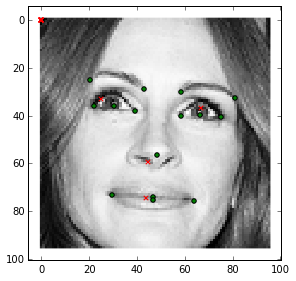

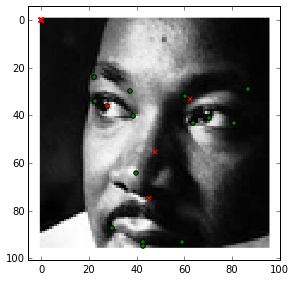

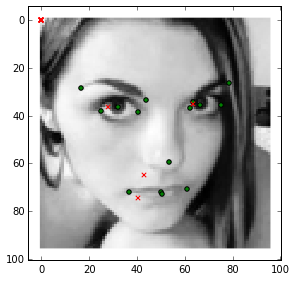

*** Score using a naive knn approach: 43.1253329178


In [452]:
show_one_example(training_data[0], training_labels[0], dev_knn_predictions[0])
show_one_example(training_data[1], training_labels[1], dev_knn_predictions[1])
show_one_example(training_data[2], training_labels[2], dev_knn_predictions[2])
print('*** Score using a naive knn approach: ' + str(development_score(dev_knn_predictions)))

In [453]:
development_score(dev_knn_predictions)

43.125332917809907

## 6) Finding 3 key regions (left eye, right eye, mouth and nose)

We will model the regions with 3 circles and transform the label set into the centers and radii of each circle
(left eye, right eye, mouth and nose)

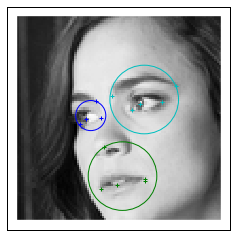

In [454]:
label_name_index = {
    name: index
    for index, name
    in enumerate(label_names)
}

def get_named_label(labels, name):
    return labels[label_name_index[name]]

def get_x(point):
    return point[0]

def get_y(point):
    return point[1]

def get_r(circle):
    return circle[2]

def points_to_circles(points):
    non_nan_points = [
        point
        for point 
        in points
        if (not np.isnan(get_x(point)) ) and (not np.isnan(get_y(point)))
    ]
    
    if len(non_nan_points) > 0:
    
        X = [ get_x(point) for point in non_nan_points ]
        Y = [ get_y(point) for point in non_nan_points ]

        centroid = [ np.mean(X), np.mean(Y) ]
        radius = np.max([ distance.euclidean(point, centroid) for point in non_nan_points  ])
        return [ get_x(centroid), get_y(centroid), radius ]
    else: 
        return None
    
def labels_to_circles(labels):
    def value(name):
        return get_named_label(labels, name)
    
    left_eye_points = [
        [ value('left_eye_center_x'), value('left_eye_center_y') ],
        [ value('left_eye_inner_corner_x'), value('left_eye_inner_corner_y') ],
        [ value('left_eye_outer_corner_x'), value('left_eye_outer_corner_y') ],
        [ value('left_eyebrow_inner_end_x'), value('left_eyebrow_inner_end_y') ],
        [ value('left_eyebrow_outer_end_x'), value('left_eyebrow_outer_end_y') ]
    ]
    
    right_eye_points = [
        [ value('right_eye_center_x'), value('right_eye_center_y') ],
        [ value('right_eye_inner_corner_x'), value('right_eye_inner_corner_y') ],
        [ value('right_eye_outer_corner_x'), value('right_eye_outer_corner_y') ],
        [ value('right_eyebrow_inner_end_x'), value('right_eyebrow_inner_end_y') ],
        [ value('right_eyebrow_outer_end_x'), value('right_eyebrow_outer_end_y') ]
    ]
    
    mouth_and_nose_points = [
        [ value('mouth_center_bottom_lip_x'), value('mouth_center_bottom_lip_y') ],
        [ value('mouth_left_corner_x'), value('mouth_center_top_lip_y') ],
        [ value('mouth_left_corner_x'), value('mouth_left_corner_y') ],
        [ value('mouth_right_corner_x'), value('mouth_right_corner_y') ],
        [ value('nose_tip_x'), value('nose_tip_y') ]
    ]
    
    return [
        points_to_circles(left_eye_points), 
        points_to_circles(right_eye_points),
        points_to_circles(mouth_and_nose_points),
        left_eye_points,
        right_eye_points,
        mouth_and_nose_points
    ]

def get_left_eye_circle(circle_labels):
    return circle_labels[0] if len(circle_labels) > 0 else None

def get_right_eye_circle(circle_labels):
    return circle_labels[1] if len(circle_labels) > 1 else None

def get_mouth_and_nose_circle(circle_labels):
    return circle_labels[2] if len(circle_labels) > 2 else None


def show_one_example_circles(example, 
                             circle_labels = None, 
                             circle_predictions = None, 
                             existing_figure = None,
                             subplot_rows = 1,
                             subplot_columns = 1,
                             subplot_number = 1
                            ):
    pixels = len(example)
    side = int(np.sqrt(pixels))
    matrix = np.reshape(255 - example, (side, side))
    
    figure = plt.figure() if (existing_figure is None) else existing_figure
    subplot = figure.add_subplot(subplot_rows, subplot_columns, subplot_number)
        
    subplot.imshow(matrix, cmap='Greys', interpolation='Nearest')
    subplot.set_xticks(np.array([]))
    subplot.set_yticks(np.array([]))
    
    def show_circle(circle, color, points = None, marker = None):
        if circle is not None:
            circle_plt = plt.Circle(
                [ get_x(circle), get_y(circle)], 
                get_r(circle), 
                color=color, 
                fill=False
            )
            plt.gca().add_artist(circle_plt)
        
        if points is not None:
            X = [ get_x(point) for point in points ]
            Y = [ get_y(point) for point in points ]
            subplot.scatter(X, Y, c = color, marker = marker)
        
    if circle_labels is not None:
        
        left_eye_circle = get_left_eye_circle(circle_labels)
        right_eye_circle = get_right_eye_circle(circle_labels)
        mouth_and_nose_circle = get_mouth_and_nose_circle(circle_labels)
        
        left_eye_points = None
        right_eye_points = None
        mouth_and_nose_points = None

        left_eye_points = circle_labels[3] if (len(circle_labels) > 3) else None
        right_eye_points = circle_labels[4] if (len(circle_labels) > 3) else None
        mouth_and_nose_points = circle_labels[5] if (len(circle_labels) > 3) else None
        
        show_circle(left_eye_circle, 'c', left_eye_points, '+')
        show_circle(right_eye_circle, 'b', right_eye_points, '+')
        show_circle(mouth_and_nose_circle, 'g', mouth_and_nose_points, '+')

    if circle_predictions is not None:
        pred_left_eye_circle = get_left_eye_circle(circle_predictions)
        pred_right_eye_circle = get_right_eye_circle(circle_predictions)
        pred_mouth_and_nose_circle = get_mouth_and_nose_circle(circle_predictions)
        
        show_circle(pred_left_eye_circle, 'm')
        show_circle(pred_right_eye_circle, 'r')
        show_circle(pred_mouth_and_nose_circle, 'orange')
    
    if existing_figure is None:
        plt.show()
        
circle_labels_3 = labels_to_circles(training_labels[3])
show_one_example_circles(training_data[3], circle_labels_3)



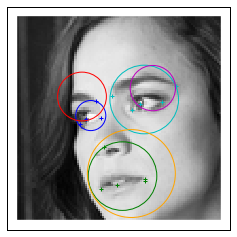

In [373]:
fake_bad_predictions = labels_to_circles(training_labels[4])
show_one_example_circles(training_data[3], circle_labels_3, fake_bad_predictions)

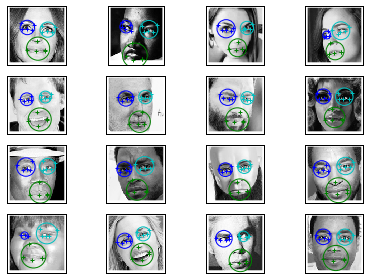

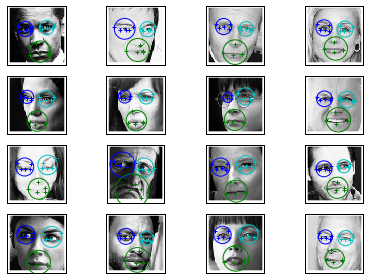

In [455]:
def show_many_examples_circles(examples, 
                               circle_labels_array = None, 
                               circle_predictions_array = None,
                               columns = 4,
                              ):
    
    count = len(examples)
    
    rows = int(np.ceil( (1.0 * count) / (1.0 * columns) ))
    
    figure = plt.figure()
    for index, example in enumerate(examples):
        circle_labels = circle_labels_array[index] if (not (circle_labels_array is None)) else None
        circle_predictions = circle_predictions_array[index] if (not (circle_predictions_array is None)) else None
        
        show_one_example_circles(example, 
                             circle_labels, circle_predictions, 
                             figure, rows, columns, index + 1)
        
    #show_one_example_circles(examples[1], 
    #                         circle_labels_array, circle_predictions_array, 
    #                         figure, rows, columns, 2)
    figure.tight_layout()
    plt.show()
    pass

training_circle_labels = np.array([ labels_to_circles(labels) for labels in training_labels ])

show_many_examples_circles( training_data[range(16)], training_circle_labels[range(16)] )
show_many_examples_circles( training_data[range(16, 32)], training_circle_labels[range(16, 32)] )

## 7) The eye is the window the to the soul

-- every poet ever

### let's build a left eye detector!


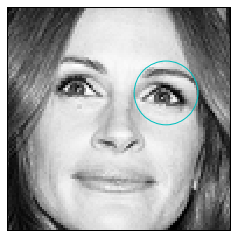

In [458]:
training_0_left_eye_only_circle = np.array([ training_circle_labels[0][0], None, None ])
show_one_example_circles(training_data[0], training_0_left_eye_only_circle)

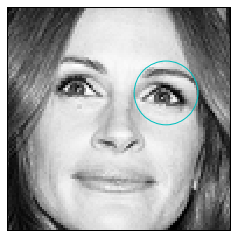

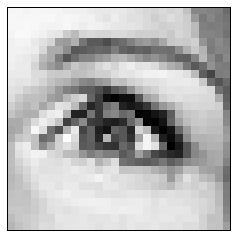

In [459]:

def excise(example, circle):
    pixels = len(example)
    side = int(np.sqrt(pixels))
    matrix = np.reshape(example, (side, side))
    
    def lookup(arg_x, arg_y):
        if (arg_x >= 0) and (arg_x < side) and (arg_y >= 0) and (arg_y < side):
            return matrix[arg_y][arg_x]
        else:
            return 0
    
    if circle is not None:
        circle_x = int(np.round(get_x(circle)))
        circle_y = int(np.round(get_y(circle)))
        circle_r = int(np.ceil(get_r(circle)))

        x_min = circle_x - circle_r
        x_max = circle_x + circle_r
        y_min = circle_y - circle_r
        y_max = circle_y + circle_r

        submatrix = np.array([
            np.array([
                lookup(iter_x, iter_y)
                for iter_y in
                range(y_min, y_max)
            ])
            for iter_x in
            range(x_min, x_max)
        ])

        return np.ravel(np.transpose(submatrix))
    else:
        return None

show_one_example_circles(training_data[0], training_0_left_eye_only_circle)
left_eye_0 = excise(training_data[0], left_eye_circle(training_circle_labels[0]))
show_one_example_circles(left_eye_0)

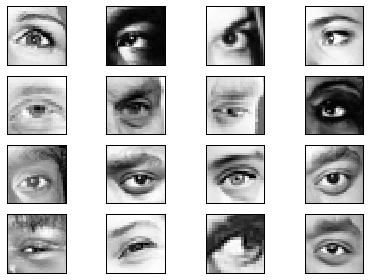

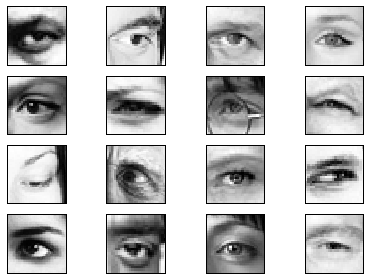

In [460]:
def sample_left_eyes(data, start, end):    
    return [
        excise(data[index], left_eye_circle(training_circle_labels[index]))
        for index
        in range(start, end)
    ]

show_many_examples_circles( sample_left_eyes(training_data, 0, 16) )
show_many_examples_circles( sample_left_eyes(training_data, 16, 32) )

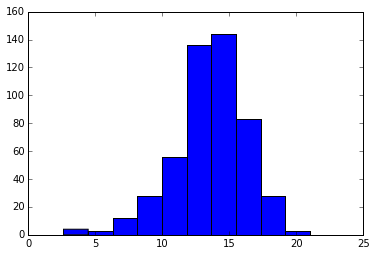

In [461]:
left_eye_circles = [ left_eye_circle(training_circle_labels[index]) for index in range(len(training_circle_labels)) ]

left_eye_circle_radii = [ 
    r(circle)
    for circle 
    in left_eye_circles 
    if circle is not None and len(circle) > 2 and r(circle) > 0.0 
]
plt.hist(left_eye_circle_radii);


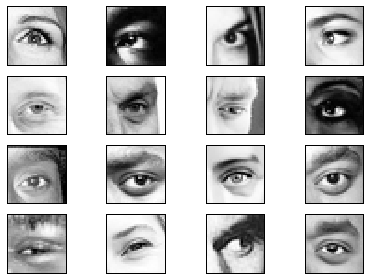

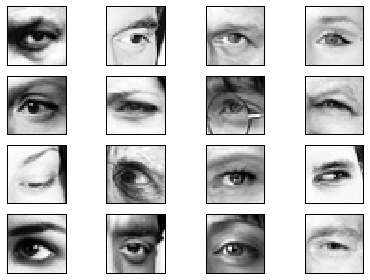

In [462]:
def circle_constrain_radius(circle, radius):
    if circle is not None:
        return [ get_x(circle), get_y(circle), radius ]
    else:
        return None
    
def sample_left_eyes_constrain_radius(data, start, end, radius):    
    return [
        excise(
            data[index], 
            circle_constrain_radius(
                left_eye_circle(training_circle_labels[index]),
                radius
            )
        )
        for index
        in range(start, end)
    ]

show_many_examples_circles( sample_left_eyes_constrain_radius(training_data, 0, 16, 16) )
show_many_examples_circles( sample_left_eyes_constrain_radius(training_data, 16, 32, 16) )

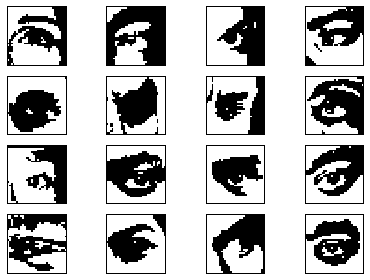

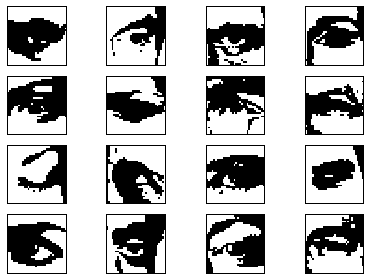

In [463]:
def binarize_at_mean(image):
    mean = np.mean(image)
    return np.array([
            255 if pixel > mean else 0
            for pixel
            in image
    ])

def binarize_all_at_mean(images):
    return np.array([
            binarize_at_mean(image)
            for image
            in images
            if image is not None
            ]);
show_many_examples_circles( binarize_all_at_mean(sample_left_eyes_constrain_radius(training_data, 0, 16, 16)) )
show_many_examples_circles( binarize_all_at_mean(sample_left_eyes_constrain_radius(training_data, 16, 32, 16)) )

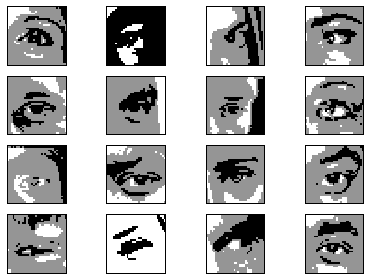

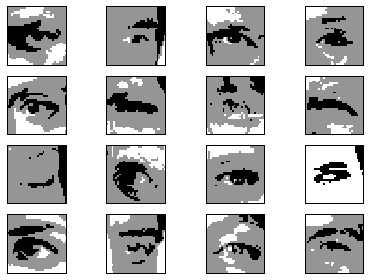

In [464]:
def ternarize_map_pixel(pixel, mean, sd, display = False):
    if pixel < mean - sd:
        return 0 if display == True else -1
    elif pixel < mean + sd:
        return 127 if display == True else 0
    else:
        return 255 if display == True else 1

def ternarize_around_mean(image, display = False):
    mean = np.mean(image)
    sd = np.std(image)
    return np.array([
            ternarize_map_pixel(pixel, mean, sd, display)
            for pixel
            in image
    ])

def ternarize_all_around_mean(images, display = False):
    return np.array([
            ternarize_around_mean(image, display)
            for image
            in images
            if image is not None
            ]);
show_many_examples_circles( ternarize_all_around_mean(sample_left_eyes_constrain_radius(training_data, 0, 16, 16), True) )
show_many_examples_circles( ternarize_all_around_mean(sample_left_eyes_constrain_radius(training_data, 16, 32, 16), True) )

In [465]:
mini_train_data = training_data[range(100)]
mini_train_labels = training_labels[range(100)]
mini_train_circle_labels = training_circle_labels[range(100)]

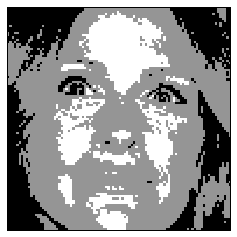

In [466]:
show_one_example_circles(ternarize_around_mean(training_data[0], True))

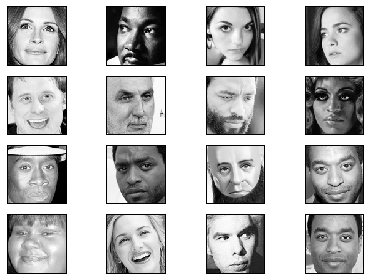

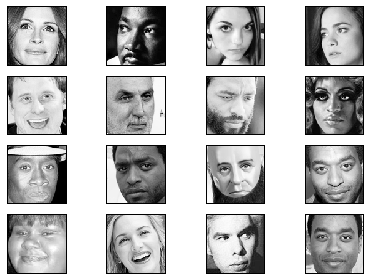

*** un-normalized mean: 138.544053819
*** un-normalized stddev: 67.6340218121
*** normalized mean: 127.500976562
*** normalized stddev: 42.5046744662


In [472]:
def normalize_map_pixel(pixel, mean, sd, display = False):
    if sd >= 1.0:
        z_score = (1.0 * pixel - 1.0 * mean) / (1.0 * sd)
    else:
        z_score = 0.0
    
    if display:
        # map z-score = [-3, 3] to [0, 255]
        value = 127.5 + (127.5 * z_score / 3.0)
        if value < 0.0:
            return 0
        elif value > 255.0:
            return 255
        else:
            return int(np.round(value))
    else:
        return z_score
    

def normalize_around_mean(image, display = False):
    mean = np.mean(image)
    sd = np.std(image)
    return np.array([
            normalize_map_pixel(pixel, mean, sd, display)
            for pixel
            in image
    ])

def normalize_all_around_mean(images, display = False):
    return np.array([
            normalize_around_mean(image, display)
            for image
            in images
            if image is not None
            ]);

show_many_examples_circles( training_data[range(16)] )
show_many_examples_circles( normalize_all_around_mean( training_data[range(16)], True ) )
print('*** un-normalized mean: ' + str(np.mean(training_data[0])))
print('*** un-normalized stddev: ' + str(np.std(training_data[0])))
print('*** normalized mean: ' + str(np.mean(normalize_around_mean(training_data[0], True))))
print('*** normalized stddev: ' + str(np.std(normalize_around_mean(training_data[0], True))))

## 8) Show me your eye patch



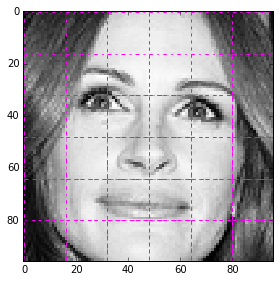

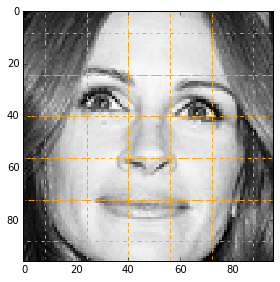

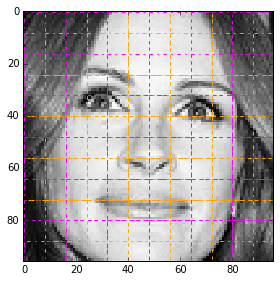

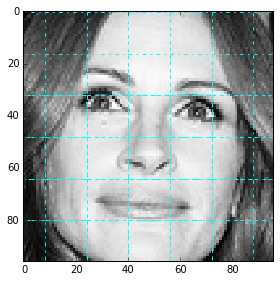

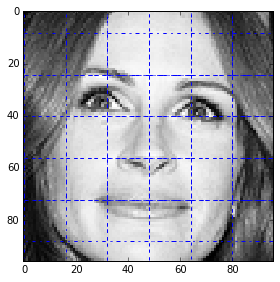

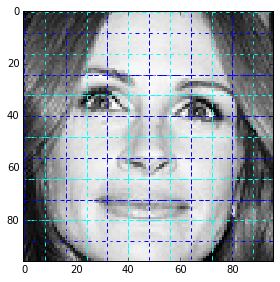

In [512]:
def generate_eye_patches(radius = 16, side = 92):
    increment = radius / 2
    eye_patches = np.array([
        [ x, y, radius ]
        for y in range(increment, side + increment, increment)
        for x in range(increment, side + increment, increment)
    ])
    
    return eye_patches

eye_patches_radius_16 = generate_eye_patches(16, 92)

def show_eye_patching(example, eye_patches, radius = 16, 
                      show_grid = True, show_syncopation = False,
                      show_syncopation_x = False, show_syncopation_y = False
                     ):
    matrix = np.reshape(255 - example, (96, 96))
    plt.imshow(matrix, cmap='Greys', interpolation='Nearest')
    
    for eye_patch in eye_patches:
        corner_x = get_x(eye_patch) - radius
        corner_y = get_y(eye_patch) - radius
        
        if (corner_x % radius == 0) and (corner_y % radius == 0):
            if show_grid:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='magenta', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)
        elif not (corner_x % radius == 0) and not (corner_y % radius == 0):
            if show_syncopation:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='orange', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)
        elif not (corner_x % radius == 0) and (corner_y % radius == 0):
            if show_syncopation_x:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='cyan', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)
        else:
            if show_syncopation_y:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='blue', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)

    plt.tight_layout()
    plt.show()
    
show_eye_patching(training_data[0], eye_patches_radius_16, 16, True, False, False, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, True, False, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, True, True, False, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, False, True, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, False, False, True)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, False, True, True)


In [504]:
96/12

8

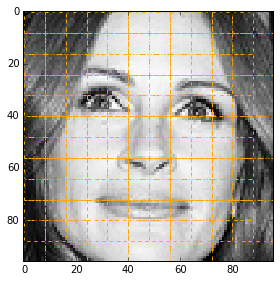

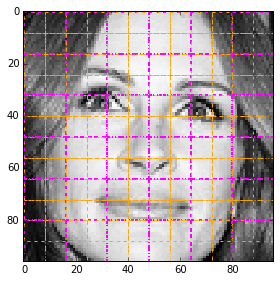

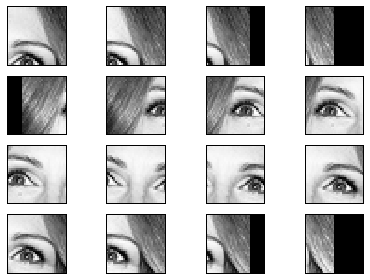

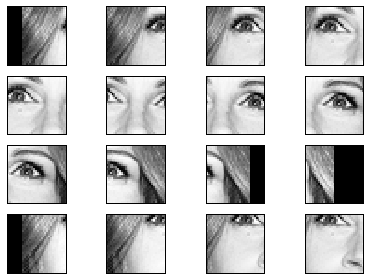

In [513]:
show_many_examples_circles([
            excise(training_data[0], eye_patch) 
            for eye_patch in eye_patches_radius_16[range(32, 48)]
        ], [
            
        ])
show_many_examples_circles([
        excise(training_data[0], eye_patch) 
        for eye_patch in eye_patches_radius_16[range(48, 64)]
        ])


In [403]:
def get_circle_center(circle):
    if circle is not None:
        return [ get_x(circle), get_y(circle) ]
    else:
        return None

left_eye_circle_0 = get_left_eye_circle(training_circle_labels[0])
left_eye_circle_0_center = get_circle_center(left_eye_circle_0)
print(left_eye_circle_0_center)

zero_value_distance = 16.0 * np.sqrt(2.0)

def map_distance(distance):
    fitness = (zero_value_distance - distance) / zero_value_distance
    return fitness if fitness > 0.0 else 0.0

#left_eye_detector_train_patches
left_eye_detector_train_data = [
    excise(example, eye_patch)
    for eye_patch in eye_patches
    for example in mini_train_data
]
left_eye_detector_train_labels = np.array([ 
        map_distance(
            distance.euclidean(
                get_circle_center(eye_patch), 
                get_circle_center(get_left_eye_circle(circle_label))
            )
        )
        for eye_patch in eye_patches
        for circle_label in mini_train_circle_labels
    ])
#get_left_eye_circle(training_circle_labels[0])

[67.832623298919998, 36.634953908760004]


In [404]:
np.shape(left_eye_detector_train_data)

(10000, 1024)

In [405]:
left_eye_detector_train_data[0]

array([  0,   0,   0, ...,  84, 121, 113])

In [408]:
rbm = BernoulliRBM(random_state=0, verbose=True)

In [428]:
rbm.learning_rate = 0.06
rbm.n_iter = 100

rbm.n_components = 250
rbm.fit(left_eye_detector_train_data, left_eye_detector_train_labels)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -72918427.09, time = 6.62s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -145794727.29, time = 7.58s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -218671027.49, time = 7.47s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -291547327.69, time = 7.72s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -364423627.89, time = 7.42s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -437299928.08, time = 7.39s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -510176228.28, time = 7.39s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -583052528.48, time = 7.51s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -655928828.68, time = 7.71s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -728805128.88, time = 7.41s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -801681429.08, time = 7.40s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -874557729.28, time = 7.86s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -947434029.48, time = 7.53s
[Bernoull

BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=250, n_iter=100,
       random_state=0, verbose=True)

In [438]:
detections = rbm.score_samples(example_0_patches)

In [443]:
left_eye_detector_train_labels[range(len(eye_patches))]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
rbm.learning_rate = 0.06
rbm.n_iter = 100

rbm.n_components = 250
rbm.fit(left_eye_detector_train_data, left_eye_detector_train_labels)



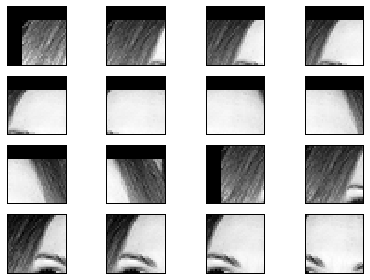

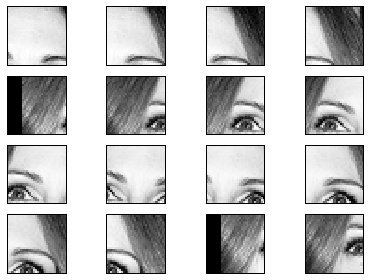

In [437]:
example_0_patches = np.array([
    excise(mini_train_data[0], eye_patch)
    for eye_patch in eye_patches
])

show_many_examples_circles(example_0_patches[range(0,16)])
show_many_examples_circles(example_0_patches[range(16,32)])



#detections = rbm.score_samples(example_0_patches)
#detections

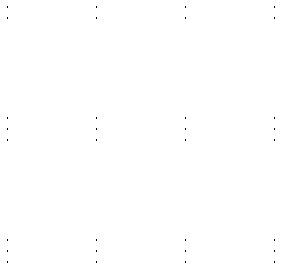

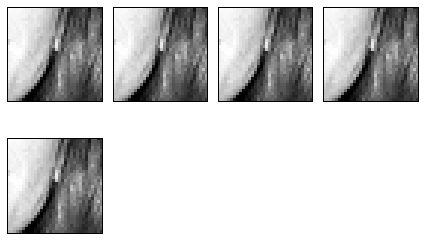

In [432]:
X = [
    get_x(eye_patches[index])
    for index, value in enumerate(detections)
    if not value == 0.0
]

Y = [
    get_y(eye_patches[index])
    for index, value in enumerate(detections)
    if not value == 0.0
]

detected = np.array([
    excise(mini_train_data[0], eye_patch)
    for index, value in enumerate(detections)
    if not value == 0.0
])

np.shape(detected)

show_many_examples_circles(example_0_patches)
show_many_examples_circles(detected)


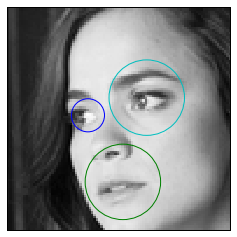

In [203]:
def circles_to_vector(circles):
    left_eye_circle = circles[0]
    right_eye_circle = circles[1]
    mouth_and_nose_circle = circles[2]
    
    return [ 
        x(left_eye_circle), y(left_eye_circle), r(left_eye_circle),
        x(right_eye_circle), y(right_eye_circle), r(right_eye_circle),
        x(mouth_and_nose_circle), y(mouth_and_nose_circle), r(mouth_and_nose_circle)
    ]

def vector_to_circles(vector):
    left_eye_circle = [ vector[0], vector[1], vector[2] ]
    right_eye_circle = [ vector[3], vector[4], vector[5] ]
    mouth_and_nose_circle = [ vector[6], vector[7], vector[8] ]
    
    return [
        left_eye_circle,
        right_eye_circle,
        mouth_and_nose_circle
    ]
        
vector_3 = circles_to_vector(circle_labels_3)

show_one_example_circles(training_data[3], vector_to_circles(vector_3))